# Example Notebook for plotting a fluxrope

In [49]:
%load_ext autoreload

%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

import datetime as datetime
from datetime import timedelta
import seaborn as sns
import pandas as pd

import copy as cp

import py3dcore_h4c as py3dcore_h4c

import fluxplot as fp

import warnings
warnings.filterwarnings('ignore')

print(sns.__version__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
0.12.2


## simple speed calculation

In [50]:
#cor2 fov

r1=13*695000


#time in minutes from COR2 inner to outer
t1=90*60


speed=r1/t1

print('CME speed STEREO-A',speed)


#LASCO

CME speed STEREO-A 1673.148148148148


## ICMECAT

In [51]:
url='https://helioforecast.space/static/sync/icmecat/HELIO4CAST_ICMECAT_v21.csv'
ic=pd.read_csv(url)
ic=ic.drop(columns='Unnamed: 0') #drop an extra index column

iwin=np.where(ic.sc_insitu=='Wind')[0]
ista=np.where(ic.sc_insitu=='STEREO-A')[0]
istb=np.where(ic.sc_insitu=='STEREO-B')[0]

i1au=np.sort(np.hstack([iwin,ista,istb]))
print('ICMECAT events near 1 AU',len(i1au))

ICMECAT events near 1 AU 856


## py3DCORE

In [52]:
t_launch = datetime.datetime(2022, 9, 5, 17, 0, 0)

#2022 Sep 5: 3 solar radii at 17 UT (COR2 & LASCO FoV appearance)

In [66]:

iparams_arr = np.array([[
    0,      # time offset
    160,    # l_1 (longitude) HEEQ
    0,#-20,    # l_2 (latitude)
    5,      # o (inclination, orientation)
    0.2,   # d_1au (frontal width at 1AU)
    3,   # delta (cross-section aspect ratio)
    3,      # r_0 (initialization distance in solar radii)
    1400,    # v_0 (initial velocty in)
    4,      # tau (magnetic field twist)
    1.0,      # b_s (magnetic field scaling parameter)
    25,     # b_1au (magnetic field strength at 1au)
    0.5,    # Gamma (solar wind drag coefficient)
    500,    # v_sw (solar wind speed)
    0       # sigma (measurement noise)
]], dtype=np.float32)

In [67]:
overwrite = {
    "cme_longitude": {
            "maximum": 161,
            "minimum": 159
        },
    "cme_latitude": {
            "maximum": 1,
            "minimum": -1
        },
    "cme_inclination" :{
            "maximum": 6,
            "minimum": 4
        },
    "cme_diameter_1au" :{
            "maximum": 0.25,
            "minimum": 0.15
        },
    "cme_aspect_ratio": {
            "maximum": 3.1,
            "minimum": 2.9
        },
    "cme_launch_radius": {
            "distribution": "uniform",
            "maximum": 4,
            "minimum": 2
        },
    "cme_launch_velocity": {
            "maximum": 1425,
            "minimum": 1365
        },
    "t_factor": {
            "maximum": 4.1,
            "minimum": 3.9
        },
    "magnetic_field_strength_1au": {
            "maximum": 56,
            "minimum": 54
        },
    "background_drag": {
            "maximum": 0.6,
            "minimum": 0.4
        },
    "background_velocity": {
            "maximum": 505,
            "minimum": 495
        },
}


In [68]:
n = 1#number of runs

#we initialize model for 1 run with default params

model_obj = py3dcore_h4c.ToroidalModel(t_launch, n, iparams=overwrite)

    Model Parameters
    ================
        For this specific model there are a total of 14 initial parameters which are as follows:
        0: t_i          time offset
        1: lon          longitude
        2: lat          latitude
        3: inc          inclination

        4: dia          cross section diameter at 1 AU
        5: delta        cross section aspect ratio

        6: r0           initial cme radius
        7: v0           initial cme velocity
        8: T            T factor (related to the twist)

        9: n_a          expansion rate
        10: n_b         magnetic field decay rate

        11: b           magnetic field strength at center at 1AU
        12: bg_d        solar wind background drag coefficient
        13: bg_v        solar wind background speed

        There are 4 state parameters which are as follows:
        0: v_t          current velocity
        1: rho_0        torus major radius
        2: rho_1        torus minor radius
        3: b_t          magnetic field strength at center

In [69]:
# after the model has been initialized, we generate a set of random initial parameters according to the table above

model_obj.generator()
#model_obj.update_iparams(iparams_arr, seed=42)


#measurement times 
tm0 =  t_launch + datetime.timedelta(days=1.3)
tm1 =  t_launch + datetime.timedelta(days=1.5)
tm2 =  t_launch + datetime.timedelta(days=3.5)


#colors for 3dplots

c0 = 'mediumseagreen'
c1 = "xkcd:red"
c2 = "xkcd:blue"


#colors for components in plots
cbt = "xkcd:black"
cbx = "xkcd:magenta"
cby = "xkcd:orange"
cbz = "xkcd:azure"

In [70]:
############# define synthetic satellite positions - semi-circle at 0.689 AU (SolO), from -180 to +180 longitude

lonstart=-180
lonstep=5
lonend=180

lonend=lonend+lonstep
satpos=np.zeros(len(np.arange(lonstart,lonend,lonstep)),dtype=[('r',float),('lon', float),('lat', float)])
#convert to recarray
satpos = satpos.view(np.recarray)  

##### set position
satpos.r=0.689
satpos.lon=np.arange(lonstart,lonend,lonstep)
satpos.lat=0.0

print(satpos[66])

#print(satpos.r, satpos.lon)    

#another satpos definition for a semi circle at 1.0 AU
satpos2=cp.deepcopy(satpos)
satpos2.r=1.0

(0.689, 150., 0.)


## plot

In [71]:
#model_obj.iparams_arr[0][:]
model_obj.iparams_arr[0][8] = 50

ERROR


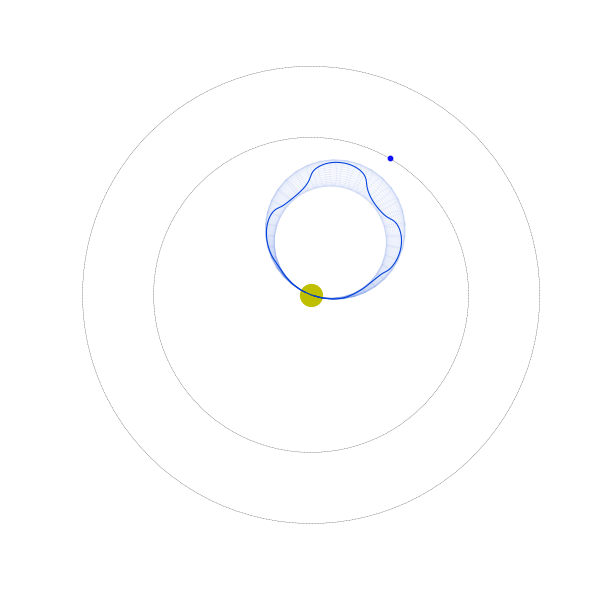

In [72]:
sns.set_context("talk")     

sns.set_style("ticks",{'grid.linestyle': '--'})
fsize=15

fig=plt.figure(1,figsize=(12,9),dpi=70)
ax = fig.add_subplot(111, projection='3d')

fp.plot_configure(ax, view_azim=0, view_elev=90, view_radius=0.8)

fp.plot_3dcore(ax, model_obj, tm0, color=c2)
fp.plot_3dcore_field(ax, model_obj, color=c2, step_size=0.005, lw=1.1, ls="-")
fp.plot_satellite(ax,satpos[66],color='blue',alpha=0.9)


# ax.plot([0,0.689],[0,0],[0,0],ls='-',color='black',lw=0.3)

fp.plot_circle(ax,0.689)
fp.plot_circle(ax,1.0)

plt.tight_layout()


#plt.savefig('results/initial_test.pdf')
#plt.savefig('initial_test.png', dpi=100)